## Case 1: Two Lines are faulted


**Single Line Diagram of system**

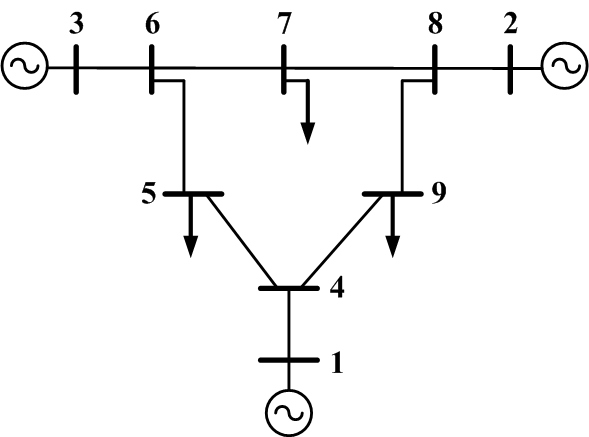

In [67]:
from IPython.display import Image
Image(filename='case1.png')

**Importing Data and packages**

In [68]:
import pandas as pd
import networkx as nx
import numpy as np
import params as params
import matplotlib.pyplot as plt

from pypower.api import ppoption, runpf, case9

grid = case9()
ppopt = ppoption(PF_ALG=1)

line_data = pd.DataFrame(grid['branch'],
                     columns=['fbus', 'tbus', 'r', 'x', 'b', 'rateA', 'rateB', 'rateC', 'ratio', 'angle', 
                              'status', 'angmin', 'angmax'])
line_data = line_data.astype({'fbus': int, 'tbus': int, 'status': int})

bus_data = pd.DataFrame(grid['bus'],
                        columns=['bus_i', 'type', 'Pd', 'Qd', 'Gs', 'Bs', 'area', 'Vm', 'Va', 'baseKV',
                                  'zone', 'Vmax', 'Vmin'])
bus_data = bus_data.astype({'bus_i': int, 'type': int})

gen_data = pd.DataFrame(grid['gen'], columns=['bus', 'Pg', 'Qg', 'Qmax', 'Qmin', 'Vg', 'mBase', 'status', 'Pmax', 
     'Pmin', 'Pc1', 'Pc2','Qc1min', 'Qc1max', 'Qc2min', 'Qc2max', 'ramp_agc', 'ramp_10', 'ramp_30', 'ramp_q', 'apf'])
gen_data = gen_data.astype({'bus': int, 'status': int})

DERs = set(gen_data['bus'])
CLs = set(bus_data['bus_i'][bus_data['Pd'] > 10])
bus_data

,bus_i,type,Pd,Qd,Gs,Bs,area,Vm,Va,baseKV,zone,Vmax,Vmin
0,1,3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
1,2,2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
2,3,2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
3,4,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
4,5,1,90.0,30.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
5,6,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
6,7,1,100.0,35.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
7,8,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9
8,9,1,125.0,50.0,0.0,0.0,1.0,1.0,0.0,345.0,1.0,1.1,0.9



#### Modification to the standard 6 bus, 3 generator system:
**A Tie Line Switch is added between bus 1 and 9**


In [69]:
line_data.loc[9] = [1, 9, 0, 0.0576, 0, 250, 250, 250, 0, 0, 0, -360, 360]
line_data = line_data.astype({'fbus': int, 'tbus': int, 'status': int})
grid['branch'] = line_data.values
line_data


,fbus,tbus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax
0,1,4,0.0000,0.0576,0.000,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
1,4,5,0.0170,0.0920,0.158,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
2,5,6,0.0390,0.1700,0.358,150.0,150.0,150.0,0.0,0.0,1,-360.0,360.0
3,3,6,0.0000,0.0586,0.000,300.0,300.0,300.0,0.0,0.0,1,-360.0,360.0
4,6,7,0.0119,0.1008,0.209,150.0,150.0,150.0,0.0,0.0,1,-360.0,360.0
5,7,8,0.0085,0.0720,0.149,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
6,8,2,0.0000,0.0625,0.000,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
7,8,9,0.0320,0.1610,0.306,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
8,9,4,0.0100,0.0850,0.176,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
9,1,9,0.0000,0.0576,0.000,250.0,250.0,250.0,0.0,0.0,0,-360.0,360.0


**Verifying normal operation of system after change using power flow calculation**

In [70]:
pf_res, success = runpf(grid)
print('power flow converged') if success else print('power flow did not converge')

PYPOWER Version 5.1.16, 05-March-2023 -- AC Power Flow (Newton)


Newton's method power flow converged in 4 iterations.

Converged in 0.01 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses              9     Total Gen Capacity     820.0        -900.0 to 900.0
Generators         3     On-line Capacity       820.0        -900.0 to 900.0
Committed Gens     3     Generation (actual)    319.0              35.0
Loads              3     Load                   315.0             115.0
  Fixed            3       Fixed                315.0             115.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          10     Losses (I^2 * Z)         4.95             51.31
Transformers       0     Branc

**Adding edges and weights to graph**

In [71]:
from utilities import Utils
utils = Utils()
G, status = utils.make_graph(line_data)


**Calculation of N-1 and N-2 branch resiliency for the network**

In [72]:
# Calculation of N-1 branch resiliency
edges = G.edges
res_list = []
net_cnt = 0
for u, v in edges:
    G.remove_edge(u, v)
    path_list = utils.find_path_list(G, CLs, DERs)
    FNs, raw_combs = utils.path_combinations(path_list)
    rsl = params.ratio_source_load(FNs, CLs, DERs)
    ops = params.switch_ops(FNs, status)
    cen = params.agg_centrality(FNs)
    obs = params.overlapping_branches(FNs)
    apl = params.avg_path_length(raw_combs)
    df = pd.DataFrame(np.array([rsl, ops, cen, obs, apl]), columns=[f"FN{i}" for i in range(1, len(rsl)+1)])
    df.index = ['rsl', 'ops', 'cen', 'obs', 'apl']
    df = df.T
    df['wtd_mean'] = (df['rsl'] * 6 + df['ops'] * 3 + df['cen'] * 1 + df['obs'] * 5 + df['apl'] * 5)/20
    df['resiliency'] = np.exp(-df['wtd_mean'])
    res_list.append(sum(df['resiliency']))
    net_cnt += df.shape[0]
    G.add_edge(u, v)


# Calculation of N-2 branch Resiliency
res_list2 = []
net_cnt2 = 0
for i, (u, v) in enumerate(edges):
    G.remove_edge(u, v)
    for j, (l, r) in enumerate(edges):
        if i == j: continue
        G.remove_edge(l, r)
        path_list = utils.find_path_list(G, CLs, DERs)
        FNs, raw_combs = utils.path_combinations(path_list)
        rsl = params.ratio_source_load(FNs, CLs, DERs)
        ops = params.switch_ops(FNs, status)
        cen = params.agg_centrality(FNs)
        obs = params.overlapping_branches(FNs)
        apl = params.avg_path_length(raw_combs)
        df = pd.DataFrame(np.array([rsl, ops, cen, obs, apl]), columns=[f"FN{i}" for i in range(1, len(rsl)+1)])
        df.index = ['rsl', 'ops', 'cen', 'obs', 'apl']
        df = df.T
        df['wtd_mean'] = (df['rsl'] * 6 + df['ops'] * 3 + df['cen'] * 1 + df['obs'] * 5 + df['apl'] * 5)/20
        df['resiliency'] = np.exp(-df['wtd_mean'])
        res_list2.append(sum(df['resiliency']))
        net_cnt2 += df.shape[0]
        G.add_edge(l, r)
    G.add_edge(u, v)


    

**Visualizing modified network**

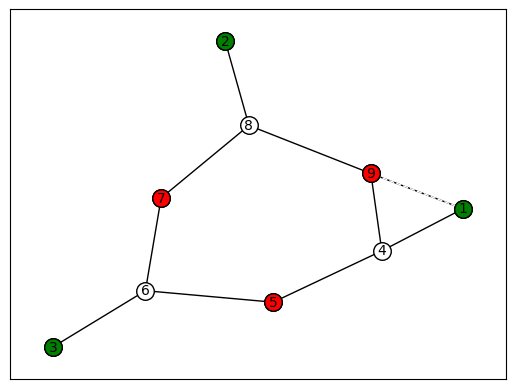

In [73]:
def plot_graph(G):
    pos = nx.layout.fruchterman_reingold_layout(G)
    options={
        'linewidths': 1,
        'edgecolors': 'black',
        'node_size': 160
    }
    nx.draw_networkx_nodes(G, pos, bus_data['bus_i'], node_color='white', **options)
    nx.draw_networkx_nodes(G, pos, CLs, node_color='red', **options)
    nx.draw_networkx_nodes(G, pos, DERs, node_color='green', **options)
    nx.draw_networkx_edges(G, pos, G.edges)
    nx.draw_networkx_edges(G, pos, [edge for edge in G.edges if status[edge] == 0], edge_color = 'white', style='dashed')
    nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, font_size=10)
    plt.show()
plot_graph(G)


#### Simulating Contingency:
**Switch in the line between bus (9 and 8), (4 and 9) is faulted resulting in islanding of bus 9.**

In [74]:
line_data = line_data.drop([7, 8])
grid['branch'] = line_data.values
line_data

,fbus,tbus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax
0,1,4,0.0000,0.0576,0.000,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
1,4,5,0.0170,0.0920,0.158,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
2,5,6,0.0390,0.1700,0.358,150.0,150.0,150.0,0.0,0.0,1,-360.0,360.0
3,3,6,0.0000,0.0586,0.000,300.0,300.0,300.0,0.0,0.0,1,-360.0,360.0
4,6,7,0.0119,0.1008,0.209,150.0,150.0,150.0,0.0,0.0,1,-360.0,360.0
5,7,8,0.0085,0.0720,0.149,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
6,8,2,0.0000,0.0625,0.000,250.0,250.0,250.0,0.0,0.0,1,-360.0,360.0
9,1,9,0.0000,0.0576,0.000,250.0,250.0,250.0,0.0,0.0,0,-360.0,360.0


**Visualizing the network after contingency**

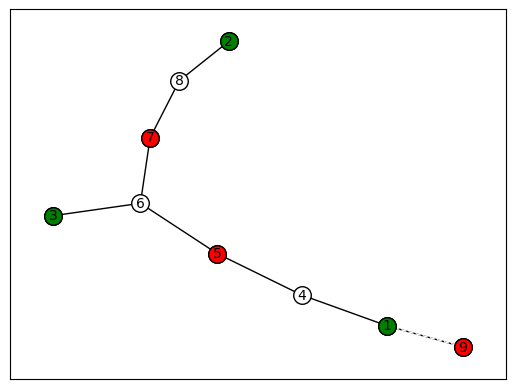

In [75]:
G, status = utils.make_graph(line_data)
plot_graph(G)

**Power flow analysis of the network after contingency**

In [76]:
try:
    pf_res, success = runpf(grid)
    print('Power flow converged') if success else print('Power flow did not converge')
except:
    print('Power flow did not converge')

PYPOWER Version 5.1.16, 05-March-2023 -- AC Power Flow (Newton)

dgstrf info 13
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1

Newton's method power did not converge in 10 iterations.
Power flow did not converge
dgstrf info 1


/Users/kakiku/BTP/.venv/lib/python3.11/site-packages/pypower/newtonpf.py:100: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F)
/Users/kakiku/BTP/.venv/lib/python3.11/site-packages/pypower/pfsoln.py:44: RuntimeWarning: invalid value encountered in cast
  gen[on, QG] = Sbus.imag * baseMVA + bus[gbus, QD]    ## inj Q + local Qd


### Finding Networks to restore the islanded critical node

**Finding all simple paths from each critical load to each source**

In [77]:
path_list = utils.find_path_list(G, CLs, DERs)

**All possible path combination calculation**

In [78]:
FNs, raw_combs = utils.path_combinations(path_list)

### Calculating parameters to measure resiliency of possible network

**Calculation of Parameter matrix**

In [79]:
rsl = params.ratio_source_load(FNs, CLs, DERs)
ops = params.switch_ops(FNs, status)
cen = params.agg_centrality(FNs)
obs = params.overlapping_branches(FNs)
apl = params.avg_path_length(raw_combs)

df = pd.DataFrame(np.array([rsl, ops, cen, obs, apl]), columns=[f"FN{i}" for i in range(1, len(rsl)+1)])
df.index = ['rsl', 'ops', 'cen', 'obs', 'apl']
df = df.T
print(df)

     rsl  ops       cen  obs       apl
FN1  1.5  1.0  0.238095  0.0  1.666667
FN2  1.5  1.0  0.238095  0.0  1.666667
FN3  1.5  1.0  0.266667  0.2  1.666667
FN4  1.0  1.0  0.178571  0.0  1.666667


**Calculation of weighted mean and resiliency**

In [86]:
df['wtd_mean'] = (df['rsl'] * 6 + df['ops'] * 3 + df['cen'] * 1 + df['obs'] * 5 + df['apl'] * 5)/20
df['resiliency'] = np.exp(-df['wtd_mean'])
print('Resiliency of network considering N-1 branches: ', sum(res_list)/net_cnt)
print('Resiliency of network considering N-2 branches: ', sum(res_list2)/net_cnt2, '\n')
print('Resiliency and parameters of feasible networks for case 1:', '\n')
print(df.sort_values('resiliency', ascending=False))

Resiliency of network considering N-1 branches:  0.3772483916753444
Resiliency of network considering N-2 branches:  0.3768110702415141 

Resiliency and parameters of feasible networks for case 1: 

     rsl  ops       cen  obs       apl  wtd_mean  resiliency
FN4  1.0  1.0  0.178571  0.0  1.666667  0.875595    0.416614
FN1  1.5  1.0  0.238095  0.0  1.666667  1.028571    0.357517
FN2  1.5  1.0  0.238095  0.0  1.666667  1.028571    0.357517
FN3  1.5  1.0  0.266667  0.2  1.666667  1.080000    0.339596


**Comparing line data before and after switching to the suggested network**

In [81]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))
    
df1 = line_data[['fbus', 'tbus', 'r', 'x', 'status']]
for u, v in FNs[3]:
    line_data.loc[(line_data.fbus == u) & (line_data.tbus == v), 'status'] = 1
    line_data.loc[(line_data.fbus == v) & (line_data.tbus == u), 'status'] = 1
grid['branch'] = line_data.values
df2 = line_data[['fbus', 'tbus', 'r', 'x', 'status']]

display_side_by_side([df1, df2], ['Line data after contingency', 'Line data after reconfiguration'])



/var/folders/ym/34_l97r95s734_tzqbrstc2r0000gn/T/ipykernel_31599/4081333343.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


,fbus,tbus,r,x,status
0,1,4,0.000000,0.057600,1
1,4,5,0.017000,0.092000,1
2,5,6,0.039000,0.170000,1
3,3,6,0.000000,0.058600,1
4,6,7,0.011900,0.100800,1
5,7,8,0.008500,0.072000,1
6,8,2,0.000000,0.062500,1
9,1,9,0.000000,0.057600,0
,fbus,tbus,r,x,status
0,1,4,0.000000,0.057600,1


**Visualizing network having highest resiliency**

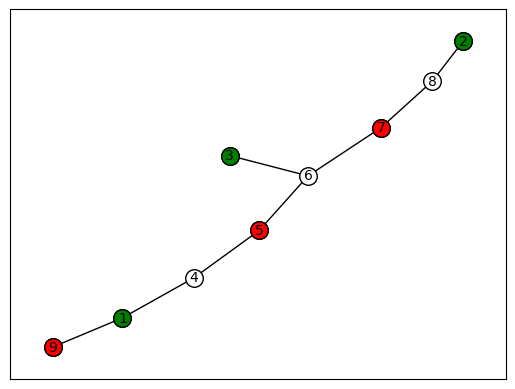

In [82]:
G, status = utils.make_graph(line_data)
plot_graph(G)

**Verification for the feasibility for the operation of the network using power flow analysis**

In [83]:
pf_res, success = runpf(grid)
print('Power flow converged') if success else print('Power flow did not converge')

PYPOWER Version 5.1.16, 05-March-2023 -- AC Power Flow (Newton)


Newton's method power flow converged in 4 iterations.

Converged in 0.01 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses              9     Total Gen Capacity     820.0        -900.0 to 900.0
Generators         3     On-line Capacity       820.0        -900.0 to 900.0
Committed Gens     3     Generation (actual)    326.0             128.0
Loads              3     Load                   315.0             115.0
  Fixed            3       Fixed                315.0             115.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches           8     Losses (I^2 * Z)        11.83             98.24
Transformers       0     Branc